# Performing aperture photometry to extract NIRCam SW data

In this notebook, we will produce corrected data from `uncal` JWST data.

For stage 1 processing, we will mainly use the `jwst` pipeline with some modifications. The main modification is the use of `refpix` step. Since the data only have reference pixels on the side of the detector, the `refpix` step will not properly correct for the odd-even effect. Therefore, we have replaced `refpix` step with group level background subtraction using ROEBA (row-by-row odd/even by amplifier correction, [Schlawin et al. 2023](https://iopscience.iop.org/article/10.1088/1538-3873/aca718)) algorithm. We also skip the `dark_current` step. After this step we will proceed as usual using `jwst` pipeline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from tqdm import tqdm
import os
import utils

In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/Data/NRC_SW'
pout = p1 + '/NRCSW/Outputs/Tests'

fname = 'jw01366002001_04103_00001-seg004_nrca3_uncal.fits'

## calwebb detector 1 processing

In [3]:
uncal = datamodels.RampModel(pin + '/' + fname)
nint = np.random.randint(0, uncal.data.shape[0])

print(uncal)

<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrca3_uncal.fits>


Meaning that the data has 65 total integration and 20 groups per integrations. An individual frame has 256 by 2048 pixels (256 rows and 2048 columns).

Let's perform `groupscale`, `dq`, `saturation` and `superbias` steps manually.

In [4]:
"""det1 = calwebb_detector1.Detector1Pipeline.call(uncal,\
                                                steps={'jump' : {'rejection_threshold' : 20., 'maximum_cores': 'all'},\
                                                       'dark_current' : {'skip' : True},\
                                                       'ramp_fit' : {'maximum_cores' : 'all'}},\
                                                output_dir=pout, save_results=True)"""

# I tried running the pipeline collectively, but it turns out that the jump step was flagging many pixels
# wrongly; maybe this is because of improper reference pixel correction step -- so now, I will manually perform
# this step using ROEBA algorithm.

groupscale_results = calwebb_detector1.group_scale_step.GroupScaleStep.call(uncal, save_results=False)
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call(groupscale_results, save_results=False)
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results, save_results=False)
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(saturation_results, save_results=False)

2023-10-18 20:22:03,466 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-10-18 20:22:03,532 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrca3_uncal.fits>,).
2023-10-18 20:22:03,533 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-10-18 20:22:03,797 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-10-18 20:22:03,798 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-10-18 20:22:03,802 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-10-18 20:22:03,825 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-10-18 20:22:03,891 - st

Let's look at the counts in one of the rows,

Text(0.5, 1.0, 'Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

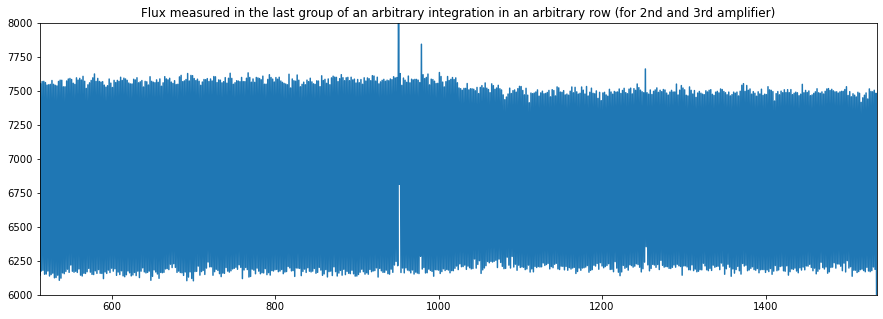

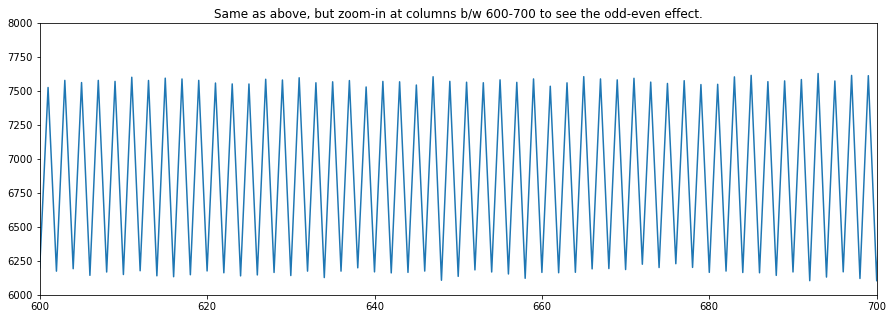

In [5]:
plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,60,:])
plt.ylim([6000,8000])
plt.xlim([512,1536])
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,60,:])
plt.ylim([6000,8000])
plt.xlim([600,700])
plt.title('Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

That's a lot of noise (both odd-even effect noise and offset noise coming from not subtracting background).

Let's now define the background region -- we will use background pixels to estimate background and then subtract it.

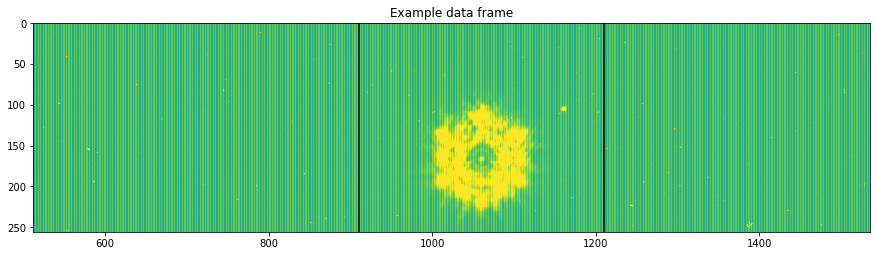

(512.0, 1536.0)

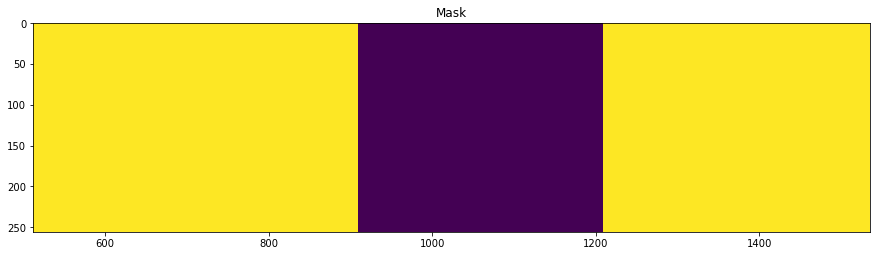

In [6]:
plt.figure(figsize=(15,5))
im = plt.imshow(superbias_results.data[0,-1,:,:], interpolation='none')
im.set_clim([-100,10000])
plt.axvline(1060-150, color='k')
plt.axvline(1060+150, color='k')
plt.xlim([512,1536])
plt.title('Example data frame')
plt.show()

m1 = np.ones(superbias_results.data[0,-1,:,:].shape)
m1[:,1060-150:1060+150] = 0.

plt.figure(figsize=(15,5))
plt.imshow(m1, interpolation='none')
plt.title('Mask')
plt.xlim([512,1536])

Okay, so now we will use this mask region to perform ROEBA-based background subtraction. Basically, we will separately perform background subtraction for each amplifier (there are 4 of them in the detector, each with 512 columns). First we will estimate background for even and odd columns separately and subtract the estimated background from even and odd columns, respectively. In the end we perform a row-by-row background subtraction. In this latter step, we simply compute median of the row to find the background. In doing all of these, we will not use masked region (marked with purple in above image).

In [7]:
# Computing ROEBA background subtraction on _group_ level
for integration in tqdm(range(superbias_results.data.shape[0])):
    for group in range(superbias_results.data.shape[1]):
        superbias_results.data[integration, group, :, :] = \
            utils.roeba_backgroud_sub(superbias_results.data[integration, group, :, :], m1)

100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Text(0.5, 1.0, 'Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

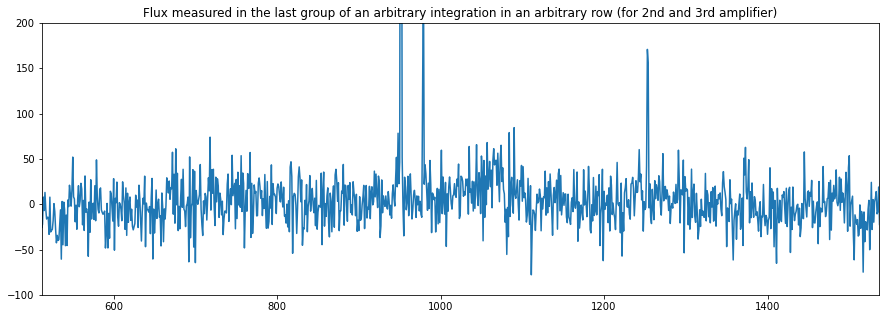

In [8]:
plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,60,:])
plt.ylim([-100,200])
plt.xlim([512,1536])
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

Awesome! Not only we took care of odd-even noise, but also performed efficient background correction!

Let's again plot the data to see how well we did,

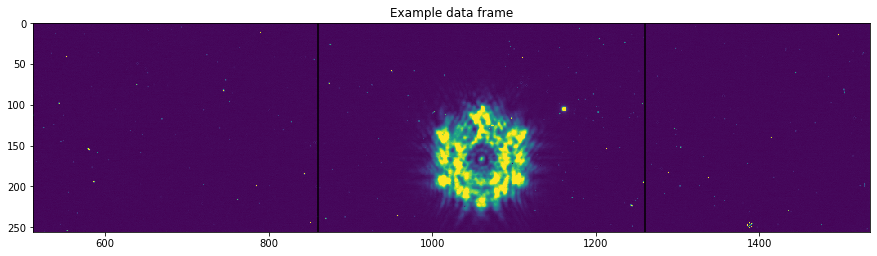

In [9]:
plt.figure(figsize=(15,5))
im = plt.imshow(superbias_results.data[0,-1,:,:], interpolation='none')
im.set_clim([-100,5000])
plt.axvline(1060-200, color='k')
plt.axvline(1060+200, color='k')
plt.xlim([512,1536])
plt.title('Example data frame')
plt.show()

Perfect! And now again continuing with the rest of the steps from the pipeline.

In [10]:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(superbias_results,
                                                                        save_results=False)
#darkcurrent_results = calwebb_detector1.dark_current_step.DarkCurrentStep.call(linearity_results,
#                                                                            save_results=False)
jumpstep_results = calwebb_detector1.jump_step.JumpStep.call(linearity_results, rejection_threshold=30.,\
                                                             maximum_cores='all', save_results=False)
rampfitting_results = calwebb_detector1.ramp_fit_step.RampFitStep.call(jumpstep_results, maximum_cores='all',\
                                                                       save_results=False)
gainscale_results = calwebb_detector1.gain_scale_step.GainScaleStep.call(rampfitting_results[1],\
                                                                         output_dir=pout, save_results=True)

2023-10-18 20:22:15,612 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-10-18 20:22:15,687 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrca3_uncal.fits>,).
2023-10-18 20:22:15,689 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-10-18 20:22:15,722 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/japa6985/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits
2023-10-18 20:22:15,882 - stpipe.LinearityStep - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2023-10-18 20:22:15,883 - stpipe.LinearityStep - WARNING - Keyword UA

Let's look at the mask:

Total per cent of masked points: 2.9650 %


(512.0, 1536.0)

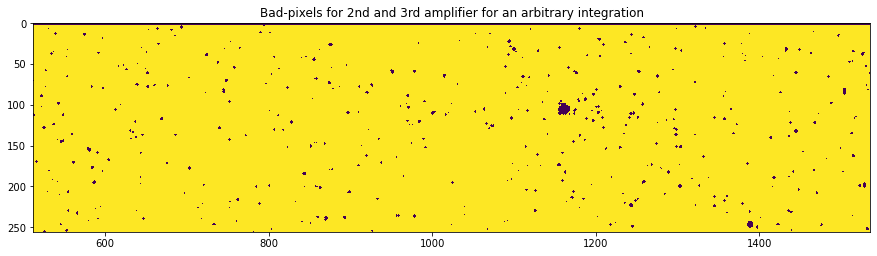

In [11]:
dq = rampfitting_results[1].dq
mask = np.ones(dq.shape)
mask[dq > 0] = 0.

print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask) / (mask.shape[0] * mask.shape[1] * mask.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask[nint,:,:], interpolation='none')
plt.title('Bad-pixels for 2nd and 3rd amplifier for an arbitrary integration')
plt.xlim([512,1536])

Okay, so there are less than 1% of pixels masked as "bad" -- not a huge number.

And this is how the data looks like,

Text(0.5, 1.0, 'Example data frame')

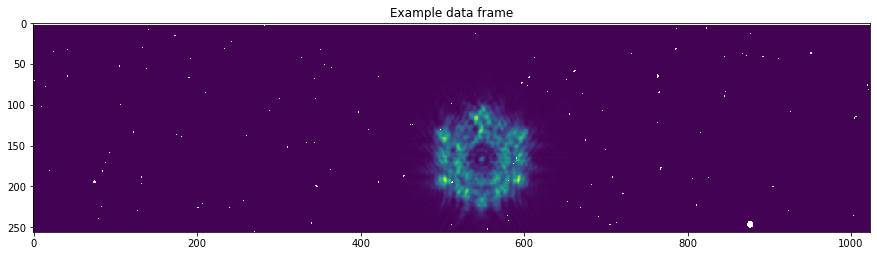

In [12]:
plt.figure(figsize=(15,5))
plt.imshow(gainscale_results.data[nint,:,512:1536], interpolation='none')
plt.title('Example data frame')

And, finally, correct the data. Starting with correcting the errorbars,

In [13]:
times_bjd = uncal.int_times['int_mid_BJD_TDB']

print('>>>> --- Correcting errorbars (for zeros and NaNs)...')
## Correct errorbars
med_err = np.nanmedian(gainscale_results.err.flatten())
## Changing Nan's and zeros in error array with median error
corr_err1 = np.copy(gainscale_results.err)
corr_err2 = np.where(gainscale_results.err != 0., corr_err1, med_err)                     # Replacing error == 0 with median error
corrected_errs = np.where(np.isnan(gainscale_results.err) != True, corr_err2, med_err)    # Replacing error == Nan with median error
print('>>>> --- Done!!')

>>>> --- Correcting errorbars (for zeros and NaNs)...
>>>> --- Done!!


And creating a bad-pixel map (this is in addition to the bad-pixel map we already have -- the idea is to include all those pixels with 0 or NaN errors in bad pixel map. Additionally, we will manually identify cosmic rays by comparing median frame with each frame and add those pixels in the bad-pixel map),

In [14]:
print('>>>> --- Creating a bad-pixel map...')
## Making a bad-pixel map
mask_bp1 = np.ones(gainscale_results.data.shape)
mask_bp2 = np.where(gainscale_results.err != 0., mask_bp1, 0.)                 # This will place 0 in mask where errorbar == 0
mask_bp3 = np.where(np.isnan(gainscale_results.err) != True, mask_bp2, 0.)     # This will place 0 in mask where errorbar is Nan
#mask_badpix = np.where(dq == 0., mask_bp3, 0.)                               # This will place 0 in mask where darkdq != 0
mask_badpix = mask * mask_bp3                                                 # Adding those pixels which are identified as bad by the pipeline (and hence 0)

## Mask with cosmic rays
### Essentially this mask will add 0s in the places of bad pixels...
mask_bcr = utils.identify_crays(gainscale_results.data, mask_badpix)
print('>>>> --- Done!!')

>>>> --- Creating a bad-pixel map...
>>>> --- Done!!


Total per cent of masked points: 2.9650 %


(512.0, 1536.0)

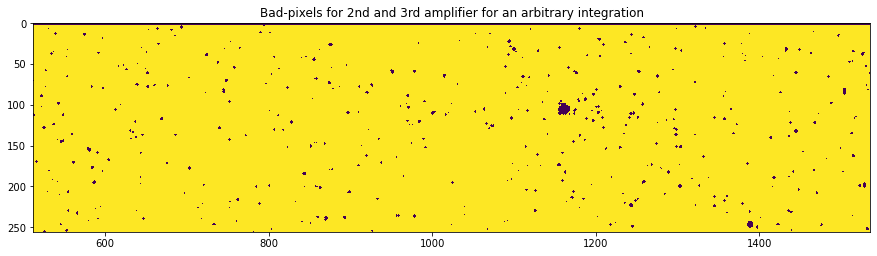

In [15]:
print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask_bcr) / (mask_bcr.shape[0] * mask_bcr.shape[1] * mask_bcr.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask_bcr[nint,:,:], interpolation='none')
plt.title('Bad-pixels for 2nd and 3rd amplifier for an arbitrary integration')
plt.xlim([512,1536])

And correct the data (meaning replacing NaN values in data-frame with average of neighbouring pixels),

In [16]:
print('>>>> --- Correcting data...')
corrected_data = np.copy(gainscale_results.data)
corrected_data[mask_bcr == 0] = np.nan
for i in range(corrected_data.shape[0]):
    corrected_data[i,:,:] = utils.replace_nan(corrected_data[i,:,:])
print('>>>> --- Done!!')

>>>> --- Correcting data...
>>>> --- Done!!


(512.0, 1536.0)

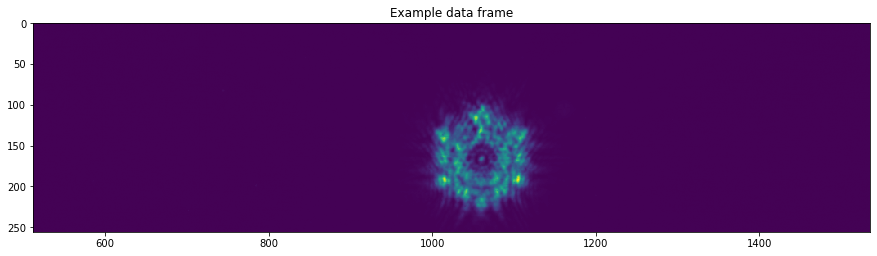

In [17]:
plt.figure(figsize=(15,5))
plt.imshow(corrected_data[nint,:,:], interpolation='None')
plt.title('Example data frame')
plt.xlim([512,1536])

Text(0.5, 1.0, 'Flux measured in an arbitrary integration in an arbitrary row')

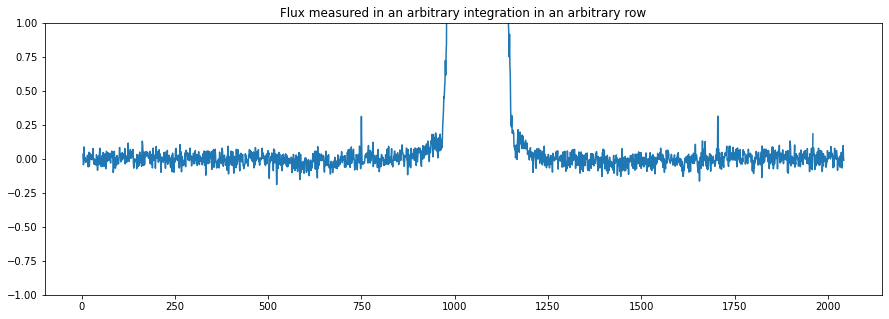

In [18]:
plt.figure(figsize=(15,5))
plt.plot(rampfitting_results[1].data[nint,175,:])
plt.ylim([-1,1])
plt.title('Flux measured in an arbitrary integration in an arbitrary row')

Saving the data,

In [19]:
np.save(pout + '/Corrected_data.npy', corrected_data[:,:,512:1536])
np.save(pout + '/Corrected_err.npy', corrected_errs[:,:,512:1536])
np.save(pout + '/Mask_bcr.npy', mask_bcr[:,:,512:1536])
np.save(pout + '/times.npy', times_bjd)